# Stochastic optimisation example

This example optimises a single node with only a wind, solar, gas and lignite generator under uncertainty about the gas price.

In Stage 1 decisions are made about capacities of the generators while the gas price is unknown.


First we solve assuming knowledge about the gas price, then stochastically according to the probability distribution of gas prices.

We then show that the average total cost of the system of the stochastically optimised capacities is lower than the means of the solutions from the deterministically determined capacities.



### Required data

For this example, we need solar and wind generation time-series. For convenience, we will be fetching the time-series data directly from the renewables.ninja server. An arbitrary example of Germany's data is retrieved. 

The fetched files: 
- PV (1985-2016, SARAH) (6.37 MB)
- Wind (Current fleet, onshore/offshore separate, MERRA-2) (13.93 MB)

See: https://www.renewables.ninja/ 


### Dependencies

In [140]:
import requests
from io import StringIO

import pypsa, pandas as pd, numpy as np
import matplotlib.pyplot as plt

from xarray import DataArray
from pypsa.optimization.common import reindex
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
from pypsa.descriptors import nominal_attrs
from pypsa.descriptors import (
    additional_linkports,
    expand_series,
    get_activity_mask,
    get_bounds_pu,
)
from linopy.expressions import LinearExpression, merge

In [141]:
%matplotlib inline

### Retrieve PV & Wind data

In [142]:
urls = {
    "solar_pu": "https://www.renewables.ninja/country_downloads/DE/ninja_pv_country_DE_sarah_corrected.csv",
    "wind_pu": "https://www.renewables.ninja/country_downloads/DE/ninja_wind_country_DE_current-merra-2_corrected.csv",
}

In [143]:
def fetch_timeseries_data(url):
    """Fetch the timeseries data from the renewable.ninja server"""

    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad responses
    
    return pd.read_csv(
        StringIO(response.text), skiprows=2, parse_dates=["time"], index_col="time"
    )["national"]

In [144]:
solar_pu = fetch_timeseries_data(urls["solar_pu"])
wind_pu = fetch_timeseries_data(urls["wind_pu"])

### Major settings

In [145]:
scenarios = ["low", "med", "high"]

# this just determines the default scenario when building stochastic model
base_scenario = "low"

# in EUR/MWh_th
gas_prices = {"low": 50, "med": 100, "high": 400}

probability = {"low": 0.4, "med": 0.3, "high": 0.3}

In [146]:
# years for weather data (solar is 1985-2015 inclusive, wind is 1980-2019)
year_start = 2015
year_end = 2015

# 1 is hourly, 3 is 3-hourly
frequency = 3

# Fixed load in MW
load = 1

# https://github.com/ERGO-Code/HiGHS
solver_name = "highs"

cts = ["DE"]

### Prepare data

In [147]:
assumptions = pd.DataFrame(
    columns=["FOM", "discount rate", "efficiency", "investment", "lifetime"],
    index=["default", "onshore wind", "utility solar PV", "gas CCGT", "lignite"],
)

assumptions.at["default", "FOM"] = 3.0
assumptions.at["default", "discount rate"] = 0.03
assumptions.at["default", "lifetime"] = 25

assumptions.at["onshore wind", "investment"] = 2e6
assumptions.at["utility solar PV", "investment"] = 10e5
assumptions.at["gas CCGT", "investment"] = 7e5
assumptions.at["gas CCGT", "efficiency"] = 0.6

assumptions.at["lignite", "investment"] = 15e5
assumptions.at["lignite", "efficiency"] = 0.3

# fill defaults
assumptions = assumptions.fillna(
    {
        "FOM": assumptions.at["default", "FOM"],
        "discount rate": assumptions.at["default", "discount rate"],
        "lifetime": assumptions.at["default", "lifetime"],
    }
)


def annuity(lifetime, rate):
    if rate == 0.0:
        return 1 / lifetime
    else:
        return rate / (1.0 - 1.0 / (1.0 + rate) ** lifetime)


# annualise investment costs, add FOM
assumptions["fixed"] = [
    (annuity(v["lifetime"], v["discount rate"]) + v["FOM"] / 100.0) * v["investment"]
    for i, v in assumptions.iterrows()
]

assumptions

,FOM,discount rate,efficiency,investment,lifetime,fixed
default,3.0,0.03,NaN,NaN,25,NaN
onshore wind,3.0,0.03,NaN,2000000.0,25,174855.742078
utility solar PV,3.0,0.03,NaN,1000000.0,25,87427.871039
gas CCGT,3.0,0.03,0.6,700000.0,25,61199.509727
lignite,3.0,0.03,0.3,1500000.0,25,131141.806559


### Required functions

In [148]:
# prepare base network (without stochastic optimisation)
def prepare_network(cts, gas_price):
    network = pypsa.Network()

    snapshots = pd.date_range(
        "{}-01-01".format(year_start),
        "{}-12-31 23:00".format(year_end),
        freq=str(frequency) + "H",
    )

    network.set_snapshots(snapshots)

    network.snapshot_weightings = pd.Series(float(frequency), index=network.snapshots)

    for ct in cts:
        network.add("Bus", ct)
        network.add("Load", ct, bus=ct, p_set=load)

        network.add(
            "Generator",
            ct + " solar",
            bus=ct,
            p_max_pu=solar_pu,
            p_nom_extendable=True,
            marginal_cost=0.01,  # Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
            capital_cost=assumptions.at["utility solar PV", "fixed"],
        )

        network.add(
            "Generator",
            ct + " wind",
            bus=ct,
            p_max_pu=wind_pu,
            p_nom_extendable=True,
            marginal_cost=0.02,  # Small cost to prefer curtailment to destroying energy in storage, solar curtails before wind
            capital_cost=assumptions.at["onshore wind", "fixed"],
        )

        network.add(
            "Generator",
            ct + " gas",
            bus=ct,
            p_nom_extendable=True,
            efficiency=assumptions.at["gas CCGT", "efficiency"],
            marginal_cost=gas_price / assumptions.at["gas CCGT", "efficiency"],
            capital_cost=assumptions.at["gas CCGT", "fixed"],
        )

        network.add(
            "Generator",
            ct + " lignite",
            bus=ct,
            p_nom_extendable=True,
            efficiency=assumptions.at["lignite", "efficiency"],
            marginal_cost=150,
            capital_cost=assumptions.at["gas CCGT", "fixed"],
        )

    return network

In [149]:
# add additional operational scenarios to the base model
def prepare_stochastic_model(n):
    m = n.optimize.create_model()

    nonbase_scenarios = scenarios.copy()
    nonbase_scenarios.remove(base_scenario)

    # we only have generators in this example, which simplifies things
    c = "Generator"
    sns = n.snapshots
    attr = "p"
    active = None
    column = "bus"
    sign = 1
    ext_i = n.get_extendable_i(c)
    min_pu, max_pu = map(DataArray, get_bounds_pu(n, c, sns, ext_i, attr))
    capacity = n.model[f"{c}-{nominal_attrs[c]}"]

    for scenario in nonbase_scenarios:
        # add extra operational variables for each non-base scenario
        dispatch = m.add_variables(
            coords=m["Generator-p"].coords, name=f"Generator-p-{scenario}"
        )
        dispatch = reindex(dispatch, c, ext_i)

        # add dispatch constraints
        lhs = dispatch - max_pu * capacity  # instead of the tuple formulation
        m.add_constraints(lhs, "<=", 0, f"{c}-ext-{attr}-upper-{scenario}", active)

        lhs = dispatch - min_pu * capacity
        m.add_constraints(lhs, ">=", 0, f"{c}-ext-{attr}-lower-{scenario}", active)

        # add nodal balance constraints
        exprs = []
        expr = DataArray(sign) * m[f"{c}-{attr}-{scenario}"]
        buses = n.df(c)[column].rename("Bus")
        expr = expr.groupby(
            buses.to_xarray()
        ).sum()  # for linopy >=0.2, see breaking changes log
        exprs.append(expr)
        lhs = merge(exprs).reindex(
            Bus=n.buses.index, fill_value=LinearExpression.fill_value
        )
        rhs = (
            (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
            .groupby(n.loads.bus, axis=1)
            .sum()
            .reindex(columns=n.buses.index, fill_value=0)
        )
        rhs.index.name = "snapshot"
        rhs = DataArray(rhs)
        mask = None
        m.add_constraints(lhs, "=", rhs, f"Bus-nodal_balance-{scenario}", mask=mask)

    # define the new objective

    objective = []
    weighting = n.snapshot_weightings.objective
    weighting = weighting.loc[sns]
    cost = (
        get_as_dense(n, c, "marginal_cost", sns)
        .loc[:, lambda ds: (ds != 0).all()]
        .mul(weighting, axis=0)
    )

    for scenario in scenarios:
        cost_modified = cost.copy()

        if scenario == base_scenario:
            name = f"{c}-{attr}"
        else:
            name = f"{c}-{attr}-{scenario}"
            cost_modified["DE gas"] = (
                cost_modified["DE gas"]
                * gas_prices[scenario]
                / gas_prices[base_scenario]
            )

        operation = m[name].sel({"snapshot": sns, c: cost.columns})
        objective.append((operation * (probability[scenario] * cost_modified)).sum())

    ext_i = n.get_extendable_i(c)
    cost = n.df(c)["capital_cost"][ext_i]
    objective.append((capacity * cost).sum())

    m.objective = merge(objective)

In [150]:
# Check that network is created correctly:
# gas_price = 30
# n = prepare_network(cts,gas_price)

### First solve capacities for each scenario deterministically

In [151]:
results = None

for scenario in scenarios:
    gas_price = gas_prices[scenario]

    n = prepare_network(cts, gas_price)

    n.optimize(solver_name=solver_name)

    if results is None:
        results = pd.DataFrame(columns=n.generators.index)
        results.index.name = "scenario"

    results.loc[scenario] = n.generators.p_nom_opt

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 106.18it/s]
INFO:linopy.io: Writing time: 0.13s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 7.88e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
13239 rows, 10323 cols, 30957 nonzeros
13239 rows, 10323 cols, 30957 nonzeros
Presolve : Reductions: rows 13239(-13045); columns 10323(-1361); elements 30957(-14406)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(34348) 0s
       7427     7.8834903072e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7427
Objective value     :  7.8834903072e+05
HiGHS run time      :          0.09


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pan

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 1.12e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a futur

13239 rows, 10323 cols, 30957 nonzeros
13239 rows, 10323 cols, 30957 nonzeros
Presolve : Reductions: rows 13239(-13045); columns 10323(-1361); elements 30957(-14406)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(34892) 0s
       7275     1.1182753980e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7275
Objective value     :  1.1182753980e+06
HiGHS run time      :          0.20


/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 104.92it/s]
INFO:linopy.io: Writing time: 0.13s
INFO:linopy.solvers:Log file at /tmp/highs.log.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
13239 rows, 10323 cols, 30957 nonzeros
13239 rows, 10323 cols, 30957 nonzeros
Presolve : Reductions: rows 13239(-13045); columns 10323(-1361); elements 30957(-14406)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(50896) 0s
       7310     1.1182753980e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7310
Objective value     :  1.1182753980e+06
HiGHS run time      :          0.20


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 1.12e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(


In [152]:
results

Generator,DE solar,DE wind,DE gas,DE lignite
scenario,,,,
low,1.388503,-0.00000,1.0,-0.000000
med,1.631694,1.92419,-0.0,0.986723
high,1.631694,1.92419,-0.0,0.986723


### Now solve the full problem stochastically

In [153]:
gas_price = gas_prices[base_scenario]

n = prepare_network(cts, gas_price)

prepare_stochastic_model(n)

n.optimize.solve_model(solver_name=solver_name)

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35044 primals, 78844 duals
Objective: 1.06e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Generator-ext-p-upper-med, Generator-ext-p-lower-med, Bus-nodal_balance-med, Generator-ext-p-upper-high, Generator-ext-p-lower-high, Bus-nodal_balance-high were not assigned to the network.


39717 rows, 30961 cols, 92871 nonzeros
39717 rows, 30961 cols, 92871 nonzeros
Presolve : Reductions: rows 39717(-39127); columns 30961(-4083); elements 92871(-43210)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(53192) 0s
      24210     1.0575733538e+06 Pr: 0(0) 2s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 24210
Objective value     :  1.0575733538e+06
HiGHS run time      :          2.58


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(


('ok', 'optimal')

In [154]:
results.loc["stochastic"] = n.generators.p_nom_opt

In [155]:
results

Generator,DE solar,DE wind,DE gas,DE lignite
scenario,,,,
low,1.388503,-0.000000,1.0000,-0.000000
med,1.631694,1.924190,-0.0000,0.986723
high,1.631694,1.924190,-0.0000,0.986723
stochastic,1.505975,1.529286,0.7761,0.926722


### Now test each set of capacities against realisations of the gas price

In [156]:
for scenario in scenarios:
    gas_price = gas_prices[scenario]
    n = prepare_network(cts, gas_price)
    n.generators.p_nom_extendable = False

    for capacity_scenario in results.index:
        n.generators.p_nom = results.loc[capacity_scenario, n.generators.index]

        print(n.generators.p_nom)

        n.optimize(solver_name=solver_name)

        results.at[capacity_scenario, f"gas-p-{scenario}"] = n.generators_t.p[
            "DE gas"
        ].sum()
        results.at[capacity_scenario, f"lignite-p-{scenario}"] = n.generators_t.p[
            "DE lignite"
        ].sum()

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

Generator
DE solar      1.388503
DE wind      -0.000000
DE gas        1.000000
DE lignite   -0.000000
Name: p_nom, dtype: float64


Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 65.73it/s]
INFO:linopy.io: Writing time: 0.1s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 6.06e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
0 rows, 0 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-26280); columns 0(-11680); elements 0(-35040) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  6.0575564285e+05
HiGHS run time      :          0.04
Generator
DE solar      1.631694
DE wind       1.924190
DE gas       -0.000000
DE lignite    0.986723
Name: p_nom, dtype: float64


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 42.44it/s]
INFO:linopy.io: Writing time: 0.11s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 5.79e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the networ

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1540 rows, 4358 cols, 4344 nonzeros
210 rows, 630 cols, 630 nonzeros
Presolve : Reductions: rows 210(-26070); columns 630(-11050); elements 630(-34410)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.7876881154e+05 Pr: 210(210) 0s
        210     5.7877726371e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
        210     5.7877717504e+05 Pr: 2(2) 0s
        214     5.7877726371e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 214
Objective value     :  5.7877726371e+05
HiGHS run time      :          0.05
Generator
DE solar      1.631694
DE wind       1.924190
DE gas       -0.000000
DE lignite    0.986723
Name: p_nom, dtype: f

/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 54.01it/s]
INFO:linopy.io: Writing time: 0.1s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 5.79e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1540 rows, 4358 cols, 4344 nonzeros
210 rows, 630 cols, 630 nonzeros
Presolve : Reductions: rows 210(-26070); columns 630(-11050); elements 630(-34410)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.7876881154e+05 Pr: 210(210) 0s
        210     5.7877726371e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
        210     5.7877717504e+05 Pr: 2(2) 0s
        214     5.7877726371e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 214
Objective value     :  5.7877726371e+05
HiGHS run time      :          0.05
Generator
DE solar      1.505975
DE wind       1.529286
DE gas        0.776100
DE lignite    0.926722
Name: p_nom, dtype: f

/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 59.04it/s]
INFO:linopy.io: Writing time: 0.11s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 3.84e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the networ

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2920 rows, 9891 cols, 9891 nonzeros
1960 rows, 7110 cols, 7110 nonzeros
Presolve : Reductions: rows 1960(-24320); columns 7110(-4570); elements 7110(-27930)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.7980261152e+05 Pr: 1960(1960) 0s
       1960     3.8374175733e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
       1960     3.8354772457e+05 Pr: 1(1) 0s
       1963     3.8374175733e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1963
Objective value     :  3.8374175733e+05
HiGHS run time      :          0.06


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pan

Generator
DE solar      1.388503
DE wind      -0.000000
DE gas        1.000000
DE lignite   -0.000000
Name: p_nom, dtype: float64


Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 60.55it/s]
INFO:linopy.io: Writing time: 0.13s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 1.21e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
0 rows, 0 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-26280); columns 0(-11680); elements 0(-35040) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  1.2114963746e+06
HiGHS run time      :          0.02
Generator
DE solar      1.631694
DE wind       1.924190
DE gas       -0.000000
DE lignite    0.986723
Name: p_nom, dtype: float64


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 56.16it/s]
INFO:linopy.io: Writing time: 0.13s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 5.79e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the networ

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1540 rows, 4358 cols, 4344 nonzeros
210 rows, 630 cols, 630 nonzeros
Presolve : Reductions: rows 210(-26070); columns 630(-11050); elements 630(-34410)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.7876881154e+05 Pr: 210(210) 0s
        210     5.7877726371e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
        210     5.7877717504e+05 Pr: 2(2) 0s
        214     5.7877726371e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 214
Objective value     :  5.7877726371e+05
HiGHS run time      :          0.03
Generator
DE solar      1.631694
DE wind       1.924190
DE gas       -0.000000
DE lignite    0.986723
Name: p_nom, dtype: f

/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 59.92it/s]
INFO:linopy.io: Writing time: 0.12s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 5.79e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the networ

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1540 rows, 4358 cols, 4344 nonzeros
210 rows, 630 cols, 630 nonzeros
Presolve : Reductions: rows 210(-26070); columns 630(-11050); elements 630(-34410)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.7876881154e+05 Pr: 210(210) 0s
        210     5.7877726371e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
        210     5.7877717504e+05 Pr: 2(2) 0s
        214     5.7877726371e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 214
Objective value     :  5.7877726371e+05
HiGHS run time      :          0.03
Generator
DE solar      1.505975
DE wind       1.529286
DE gas        0.776100
DE lignite    0.926722
Name: p_nom, dtype: f

/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 60.39it/s]
INFO:linopy.io: Writing time: 0.12s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 6.66e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the networ

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2920 rows, 9763 cols, 9763 nonzeros
1960 rows, 7110 cols, 7110 nonzeros
Presolve : Reductions: rows 1960(-24320); columns 7110(-4570); elements 7110(-27930)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     2.9869592338e+05 Pr: 1960(1960) 0s
       1960     6.6574277031e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
       1960     6.6532574104e+05 Pr: 1(1) 0s
       1963     6.6574277031e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1963
Objective value     :  6.6574277031e+05
HiGHS run time      :          0.05


/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.


Generator
DE solar      1.388503
DE wind      -0.000000
DE gas        1.000000
DE lignite   -0.000000
Name: p_nom, dtype: float64


Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 57.00it/s]
INFO:linopy.io: Writing time: 0.12s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 4.85e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
0 rows, 0 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-26280); columns 0(-11680); elements 0(-35040) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  4.8459407650e+06
HiGHS run time      :          0.02
Generator
DE solar      1.631694
DE wind       1.924190
DE gas       -0.000000
DE lignite    0.986723
Name: p_nom, dtype: float64


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 60.37it/s]
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 5.79e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the networ

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1540 rows, 4358 cols, 4344 nonzeros
210 rows, 630 cols, 630 nonzeros
Presolve : Reductions: rows 210(-26070); columns 630(-11050); elements 630(-34410)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.7876881154e+05 Pr: 210(210) 0s
        210     5.7877726371e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
        210     5.7877717504e+05 Pr: 2(2) 0s
        214     5.7877726371e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 214
Objective value     :  5.7877726371e+05
HiGHS run time      :          0.04
Generator
DE solar      1.631694
DE wind       1.924190
DE gas       -0.000000
DE lignite    0.986723
Name: p_nom, dtype: f

/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 61.14it/s]
INFO:linopy.io: Writing time: 0.12s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 5.79e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the networ

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1540 rows, 4358 cols, 4344 nonzeros
210 rows, 630 cols, 630 nonzeros
Presolve : Reductions: rows 210(-26070); columns 630(-11050); elements 630(-34410)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.7876881154e+05 Pr: 210(210) 0s
        210     5.7877726371e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
        210     5.7877717504e+05 Pr: 2(2) 0s
        214     5.7877726371e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 214
Objective value     :  5.7877726371e+05
HiGHS run time      :          0.04
Generator
DE solar      1.505975
DE wind       1.529286
DE gas        0.776100
DE lignite    0.926722
Name: p_nom, dtype: f

/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 1/1 [00:00<00:00, 50.81it/s]
INFO:linopy.io: Writing time: 0.13s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11680 primals, 26280 duals
Objective: 6.70e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the networ

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2920 rows, 9763 cols, 9763 nonzeros
1960 rows, 7110 cols, 7110 nonzeros
Presolve : Reductions: rows 1960(-24320); columns 7110(-4570); elements 7110(-27930)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     3.0319749693e+05 Pr: 1960(1960) 0s
       1960     6.7024434385e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
       1960     6.6982731458e+05 Pr: 1(1) 0s
       1963     6.7024434385e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 1963
Objective value     :  6.7024434385e+05
HiGHS run time      :          0.05


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(


In [157]:
results

Generator,DE solar,DE wind,DE gas,DE lignite,gas-p-low,lignite-p-low,gas-p-med,lignite-p-med,gas-p-high,lignite-p-high
scenario,,,,,,,,,,
low,1.388503,-0.000000,1.0000,-0.000000,2422.962927,0.000000,2422.962927,0.000000,2422.962927,0.000000
med,1.631694,1.924190,-0.0000,0.986723,0.000000,1285.992264,0.000000,1285.992264,0.000000,1285.992264
high,1.631694,1.924190,-0.0000,0.986723,0.000000,1285.992264,0.000000,1285.992264,0.000000,1285.992264
stochastic,1.505975,1.529286,0.7761,0.926722,1409.254803,69.683772,3.001049,1475.937526,3.001049,1475.937526


In [158]:
for capacity_scenario in results.index:
    for g in n.generators.index:
        results.at[capacity_scenario, f"{g} CC"] = (
            results.at[capacity_scenario, g] * n.generators.at[g, "capital_cost"]
        )

    for scenario in scenarios:
        results.at[capacity_scenario, f"DE gas-{scenario} MC"] = (
            n.snapshot_weightings.objective.mean()
            * gas_prices[scenario]
            / n.generators.at["DE gas", "efficiency"]
            * results.at[capacity_scenario, f"gas-p-{scenario}"]
        )
        results.at[capacity_scenario, f"DE lignite-{scenario} MC"] = (
            n.snapshot_weightings.objective.mean()
            * n.generators.at["DE lignite", "marginal_cost"]
            * results.at[capacity_scenario, f"lignite-p-{scenario}"]
        )

    results.at[capacity_scenario, "DE gas-mean MC"] = sum(
        [
            probability[scenario]
            * results.at[capacity_scenario, f"DE gas-{scenario} MC"]
            for scenario in scenarios
        ]
    )
    results.at[capacity_scenario, "DE lignite-mean MC"] = sum(
        [
            probability[scenario]
            * results.at[capacity_scenario, f"DE lignite-{scenario} MC"]
            for scenario in scenarios
        ]
    )

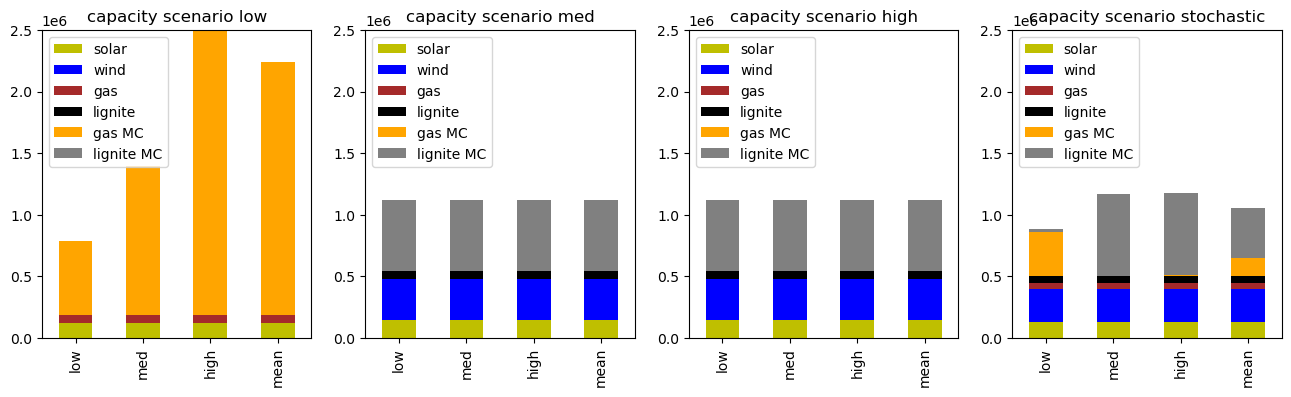

In [159]:
fig, axes = plt.subplots(1, len(results.index), figsize=(len(results.index) * 4, 4))

colors = {
    "wind": "b",
    "solar": "y",
    "lignite": "black",
    "gas": "brown",
    "gas MC": "orange",
    "lignite MC": "gray",
}

# fig.suptitle('Horizontally stacked subplots')

for i, capacity_scenario in enumerate(results.index):
    ax = axes[i]

    df = pd.DataFrame(index=scenarios + ["mean"])

    for tech in ["solar", "wind", "gas", "lignite"]:
        df[tech] = results.at[capacity_scenario, f"DE {tech} CC"]

    for scenario in scenarios + ["mean"]:
        df.at[scenario, "gas MC"] = results.at[
            capacity_scenario, f"DE gas-{scenario} MC"
        ]
        df.at[scenario, "lignite MC"] = results.at[
            capacity_scenario, f"DE lignite-{scenario} MC"
        ]

    df.plot(kind="bar", stacked=True, ax=ax, color=colors)

    ax.set_title(f"capacity scenario {capacity_scenario}")

    ax.legend(loc="upper left")

    ax.set_ylim([0, 2.5e6])

(0.0, 2000000.0)

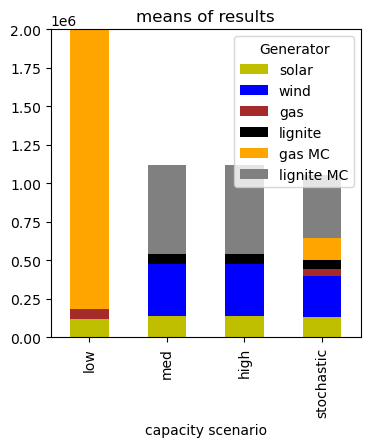

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

df = (
    results[
        [
            "DE solar CC",
            "DE wind CC",
            "DE gas CC",
            "DE lignite CC",
            "DE gas-mean MC",
            "DE lignite-mean MC",
        ]
    ]
    .rename(columns=lambda x: x[3:-3])
    .rename(columns={"gas-mean": "gas MC", "lignite-mean": "lignite MC"})
)

df.plot(kind="bar", stacked=True, ax=ax, color=colors)

ax.set_xlabel("capacity scenario")

ax.set_title("means of results")
ax.set_ylim([0, 2e6])

# Analysis of a Stochastic Solution

### The Expected costs of ignoring uncertainty (ECIU)

in some literature also defined as the Value of Stochastic Solution (VSS). Can be used interchangeably.

The natural question to ask is how much difference it really makes to the quality of the decisions reached if I use a stochastic problem instead of a deterministic problem?

The ECIU measures the value of using a stochastic model (or the expected costs of ignoring uncertainty when using a deterministic model).


In [161]:
portfolios = pd.DataFrame()
costs = pd.Series()

### Define the naive problem (usually -- the expected value problem (EV))

In [162]:
# can be anything (e.g., the 'med' scenario). A texbook way is to take expected value of uncertain parameter.

naive_scenario = sum(pd.Series(gas_prices) * pd.Series(probability))
naive_scenario
# naive_scenario = gas_prices["med"]

170.0

### solve naive problem (deterministic)

In [163]:
scenario = "naive"  # naive problem (in literature often EVP for Expected Value Problem, if the naive assumption is the expected value)
gas_price = naive_scenario

n = prepare_network(cts, gas_price)

n.optimize(solver_name=solver_name)

portfolios[scenario] = n.generators.p_nom_opt
costs[scenario] = n.objective

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
13239 rows, 10323 cols, 30957 nonzeros
13239 rows, 10323 cols, 30957 nonzeros
Presolve : Reductions: rows 13239(-13045); columns 10323(-1361); elements 30957(-14406)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(38576) 0s
       7369     1.1182753980e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7369
Objective value     :  1.1182753980e+06
HiGHS run time      :          0.23


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 1.12e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(


In [164]:
# pd.set_option("display.precision", 10)
portfolios
# costs

,naive
Generator,
DE solar,1.631694
DE wind,1.924190
DE gas,-0.000000
DE lignite,0.986723


### solve stochastic problem

In [165]:
scenario = "SP"  # SP for Stochastic Problem
gas_price = gas_prices[base_scenario]

n = prepare_network(cts, gas_price)
prepare_stochastic_model(n)

n.optimize.solve_model(solver_name=solver_name)

portfolios[scenario] = n.generators.p_nom_opt
costs[scenario] = n.objective

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
39717 rows, 30961 cols, 92871 nonzeros
39717 rows, 30961 cols, 92871 nonzeros
Presolve : Reductions: rows 39717(-39127); columns 30961(-4083); elements 92871(-43210)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(53192) 0s
      24210     1.0575733538e+06 Pr: 0(0) 2s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 24210
Objective value     :  1.0575733538e+06
HiGHS run time      :          2.50


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35044 primals, 78844 duals
Objective: 1.06e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Generator-ext-p-upper-med, Generator-ext-p-lower-med, Bus-nodal_balance-med, Generator-ext-p-upper-high, Generator-ext-p-lower-high, Bus-nodal_balance-high were not assigned to the network.
/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(


In [166]:
portfolios

,naive,SP
Generator,,
DE solar,1.631694,1.505975
DE wind,1.924190,1.529286
DE gas,-0.000000,0.776100
DE lignite,0.986723,0.926722


### Solve stochastic problem constrained by the naive solution 

In [167]:
scenario = "SP-constrained"

gas_price = gas_prices[base_scenario]
n = prepare_network(cts, gas_price)
prepare_stochastic_model(n)

n.generators.p_nom_extendable = False
n.generators.p_nom = portfolios.loc[n.generators.index, "naive"]
# n.generators.T

n.optimize.solve_model(solver_name=solver_name)

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35044 primals, 78844 duals
Objective: 1.06e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Generator-ext-p-upper-med, Generator-ext-p-lower-med, Bus-nodal_balance-med, Generator-ext-p-upper-high, Generator-ext-p-lower-high, Bus-nodal_balance-high were not assigned to the network.


Presolving model
39717 rows, 30961 cols, 92871 nonzeros
39717 rows, 30961 cols, 92871 nonzeros
Presolve : Reductions: rows 39717(-39127); columns 30961(-4083); elements 92871(-43210)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(53192) 0s
      24210     1.0575733538e+06 Pr: 0(0) 2s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 24210
Objective value     :  1.0575733538e+06
HiGHS run time      :          2.56


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(


('ok', 'optimal')

In [168]:
# don't forget to add the capital costs of the (fixed) generators portfolio
c = "Generator"
ext_i = portfolios["naive"].index
cost = n.df(c)["capital_cost"][ext_i]
cost_of_portfolio = (n.generators.p_nom * cost).sum()
n.objective += cost_of_portfolio
n.objective

1597071.488052698

In [169]:
portfolios[
    scenario
] = n.generators.p_nom  # just a fixed copy of naive problem's solution
costs[
    scenario
] = (
    n.objective
)  # must be >= than the stochastic solution's costs, because you do dispatch with the suboptimal first-stage decisions

costs

naive             1.118275e+06
SP                1.057573e+06
SP-constrained    1.597071e+06
dtype: float64

### Compute ECIU

In [170]:
# ECIU (or VSS) in M euro
eciu = (costs["SP-constrained"] - costs["SP"]) / 1e6
# ECIU in % of stochastic solution
eciu_pp = eciu / (costs["SP"] / 1e6) * 100

print(
    f"ECIU: {round(eciu, 3)} Meuro \nwhich is {round(eciu_pp)}% of stochastic solution's costs"
)

ECIU: 0.539 Meuro 
which is 51% of stochastic solution's costs


### The Expected Value of Perfect Information (EVPI)

If system planner knew at the first stage which scenario will play out, it could optimize an expansion plan (i.e. that results in lower cost) for that scenario.

The expected value (and the corresponding mathematical problem) of such solution is denoted in the literature as „wait-and-see” solution (or wait-and-see (WS) problem).

The difference between the (probability-weighted) wait-and-see solutions and the here-and-now (stochastic) solution represents the added value of information about the future (i.e., the expected profit).

*modelling perspective*: How much the expected costs could be reduced if system planner in the first stage knew exactly which scenario would happen?

*economic perspective*: An upper bound to the amount that should be paid for improved forecasts.

In [171]:
portfolios = pd.DataFrame()
costs = pd.Series()

### Solve Wait-and-See problems
where Wait-and-See (WS) is a standard textbook name for individual determinic problem (i.e. running a single scenario).

In [172]:
for scenario in scenarios:
    gas_price = gas_prices[scenario]
    n = prepare_network(cts, gas_price)

    n.optimize(solver_name=solver_name)

    if results is None:
        results = pd.DataFrame(columns=n.generators.index)
        results.index.name = "scenario"

    portfolios[scenario] = n.generators.p_nom_opt
    costs[scenario] = n.objective

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

/home/iegor/ensys/PyPSA/pypsa/optimization/constraints.py:530: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  (-get_as_dense(n, "Load", "p_set", sns) * n.loads.sign)
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 112.26it/s]
INFO:linopy.io: Writing time: 0.14s
INFO:linopy.solvers:Log file at /tmp/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 7.88e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
13239 rows, 10323 cols, 30957 nonzeros
13239 rows, 10323 cols, 30957 nonzeros
Presolve : Reductions: rows 13239(-13045); columns 10323(-1361); elements 30957(-14406)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(34348) 0s
       7427     7.8834903072e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7427
Objective value     :  7.8834903072e+05
HiGHS run time      :          0.08


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pan

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
13239 rows, 10323 cols, 30957 nonzeros
13239 rows, 10323 cols, 30957 nonzeros
Presolve : Reductions: rows 13239(-13045); columns 10323(-1361); elements 30957(-14406)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(34892) 0s
       7275     1.1182753980e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7275
Objective value     :  1.1182753980e+06
HiGHS run time      :          0.20


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 1.12e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a futur

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11684 primals, 26284 duals
Objective: 1.12e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


13239 rows, 10323 cols, 30957 nonzeros
13239 rows, 10323 cols, 30957 nonzeros
Presolve : Reductions: rows 13239(-13045); columns 10323(-1361); elements 30957(-14406)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2920(50896) 0s
       7310     1.1182753980e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7310
Objective value     :  1.1182753980e+06
HiGHS run time      :          0.21


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(


### compute the expected value of wait-and-see scenario costs

In [173]:
ws = sum(costs * pd.Series(probability))

### solve stochastic problem

In [174]:
scenario = "SP"  # SP for Stochastic Problem
gas_price = gas_prices[base_scenario]

n = prepare_network(cts, gas_price)
prepare_stochastic_model(n)

n.optimize.solve_model(solver_name=solver_name)

portfolios[scenario] = n.generators.p_nom_opt
costs[scenario] = n.objective

/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/iegor/ensys/PyPSA/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/hom

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35044 primals, 78844 duals
Objective: 1.06e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Generator-ext-p-upper-med, Generator-ext-p-lower-med, Bus-nodal_balance-med, Generator-ext-p-upper-high, Generator-ext-p-lower-high, Bus-nodal_balance-high were not assigned to the network.


39717 rows, 30961 cols, 92871 nonzeros
39717 rows, 30961 cols, 92871 nonzeros
Presolve : Reductions: rows 39717(-39127); columns 30961(-4083); elements 92871(-43210)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(53192) 0s
      24210     1.0575733538e+06 Pr: 0(0) 2s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 24210
Objective value     :  1.0575733538e+06
HiGHS run time      :          2.60


/home/iegor/ensys/PyPSA/pypsa/optimization/optimize.py:466: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  pd.concat(


### Compute EVPI

In [175]:
# EVPI in M euro
evpi = (
    costs["SP"] - ws
) / 1e6  # must be >=0 because improved information cannot make the decision maker worse
# ECIU in % of stochastic solution
evpi_pp = evpi / (costs["SP"] / 1e6) * 100

print(
    f"EVPI: {round(evpi, 3)} Meuro \nwhich is {round(evpi_pp)}% of stochastic solution's costs"
)

EVPI: 0.071 Meuro 
which is 7% of stochastic solution's costs


### Comparing the ECIU and EVPI metrics

ECIU: an investment decision is made when uncertainty is **ignored**. 
The ECIU is **the additional expected cost of assuming that future is certain**.

EVPI: an investment decision is made after uncertainty is **removed**.
The EVPI is the **expected cost of being uncertain about the future**.